# House Price Prediction – Step-by-Step (EDA → OLS/VIF → XGBoost)

This notebook builds the model **step by step**:

1. Explore data (mean, median, distributions, correlations)
2. Clean and engineer features
3. Check multicollinearity with **VIF**
4. Run **OLS regression** to interpret significance
5. Train a final **XGBoost (log target)** model on a clean 13-feature set
6. Evaluate with **MAE, MAPE, R²**
7. Save artifacts + provide a `predict_price()` function with 3 test cases


In [6]:
import pandas as pd
import numpy as np
import warnings, logging, pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import LabelEncoder

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logging.info("Imports loaded.")


2025-11-20 18:14:21,906 - INFO - Imports loaded.


In [7]:
DATA_PATH = "House_Price_India.csv"  # adjust if needed
df = pd.read_csv(DATA_PATH)
logging.info(f"Dataset loaded with shape: {df.shape}")
df.head()


2025-11-20 18:14:23,095 - INFO - Dataset loaded with shape: (30000, 26)


,id,Date,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,number of views,condition of the house,...,Lattitude,Longitude,living_area_renov,lot_area_renov,Number of schools nearby,Distance from the airport,Price,floor,property_type,city
0,6762822487,42600,3,1.75,1510,6597,1.0,0,0,4,...,17.273155,78.547122,1460,5320,1,79,7273383,5,Flat,Hyderabad
1,6762819076,42505,2,2.50,1310,1500,2.0,0,0,3,...,27.068349,80.913591,1320,1581,1,61,3946037,0,Flat,Lucknow
2,6762813616,42572,3,2.25,3270,168000,2.0,0,0,4,...,26.723329,81.040758,3220,7963,2,52,27791008,4,Flat,Lucknow
3,6762830095,42706,3,1.00,1340,10035,1.0,0,0,3,...,13.186608,77.759730,2090,10035,1,50,9255705,2,Flat,Bengaluru
4,6762815522,42568,4,2.50,2500,8540,2.0,0,0,3,...,13.040106,77.689803,2560,8475,1,61,19246155,14,Flat,Bengaluru


In [8]:
# Basic structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     30000 non-null  int64  
 1   Date                                   30000 non-null  int64  
 2   number of bedrooms                     30000 non-null  int64  
 3   number of bathrooms                    30000 non-null  float64
 4   living area                            30000 non-null  int64  
 5   lot area                               30000 non-null  int64  
 6   number of floors                       30000 non-null  float64
 7   waterfront present                     30000 non-null  int64  
 8   number of views                        30000 non-null  int64  
 9   condition of the house                 30000 non-null  int64  
 10  grade of the house                     30000 non-null  int64  
 11  Ar

In [9]:
# Summary statistics for numeric columns (mean, median, etc.)
df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,30000.0,6.762821e+09,6.279188e+03,6.762810e+09,6.762815e+09,6.762821e+09,6.762826e+09,6.762832e+09
Date,30000.0,4.260419e+04,6.733340e+01,4.249100e+04,4.254600e+04,4.260000e+04,4.266200e+04,4.273400e+04
number of bedrooms,30000.0,3.378233e+00,9.019239e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.100000e+01
number of bathrooms,30000.0,2.129067e+00,7.705512e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
living area,30000.0,2.105096e+03,9.413535e+02,3.800000e+02,1.440000e+03,1.940000e+03,2.570000e+03,1.354000e+04
lot area,30000.0,1.507904e+04,3.665925e+04,5.200000e+02,5.030750e+03,7.590000e+03,1.080000e+04,1.074218e+06
number of floors,30000.0,1.500817e+00,5.404789e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront present,30000.0,7.333333e-03,8.532173e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
number of views,30000.0,2.387667e-01,7.738930e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition of the house,30000.0,3.429800e+00,6.636414e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [10]:
# Summary statistics focused on Price
df['Price'].describe()


count    3.000000e+04
mean     1.299613e+07
std      8.872150e+06
min      2.185776e+06
25%      7.835722e+06
50%      1.098769e+07
75%      1.543464e+07
max      3.280343e+08
Name: Price, dtype: float64

In [11]:
# Missing values per column
df.isna().sum().sort_values(ascending=False)


id                                       0
Date                                     0
property_type                            0
floor                                    0
Price                                    0
Distance from the airport                0
Number of schools nearby                 0
lot_area_renov                           0
living_area_renov                        0
Longitude                                0
Lattitude                                0
Postal Code                              0
Renovation Year                          0
Built Year                               0
Area of the basement                     0
Area of the house(excluding basement)    0
grade of the house                       0
condition of the house                   0
number of views                          0
waterfront present                       0
number of floors                         0
lot area                                 0
living area                              0
number of b

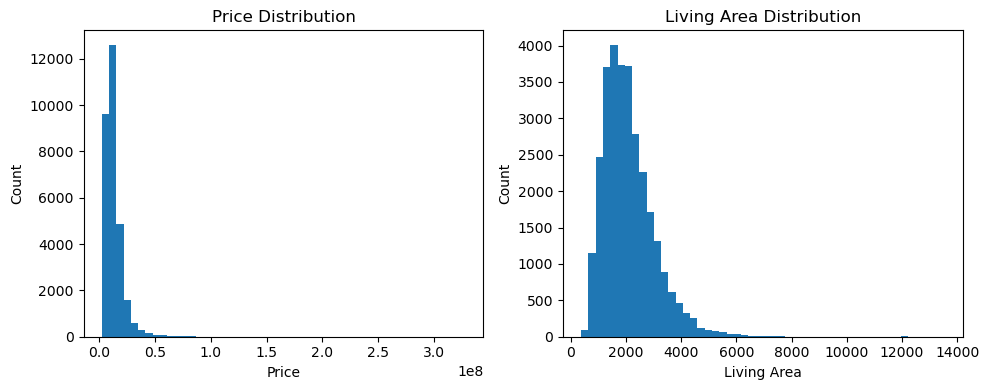

In [12]:
# Simple histograms for key variables
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['Price'], bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

if 'living area' in df.columns:
    plt.subplot(1,2,2)
    plt.hist(df['living area'], bins=50)
    plt.title('Living Area Distribution')
    plt.xlabel('Living Area')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [13]:
# Correlation matrix for a few important numeric columns (if present)
cols_for_corr = [c for c in ['Price','living area','lot area','number of bedrooms','number of bathrooms'] if c in df.columns]
corr = df[cols_for_corr].corr()
corr


,Price,living area,lot area,number of bedrooms,number of bathrooms
Price,1.000000,0.657397,0.714568,0.348834,0.468924
living area,0.657397,1.000000,0.185257,0.589940,0.759590
lot area,0.714568,0.185257,1.000000,0.045525,0.088108
number of bedrooms,0.348834,0.589940,0.045525,1.000000,0.529901
number of bathrooms,0.468924,0.759590,0.088108,0.529901,1.000000


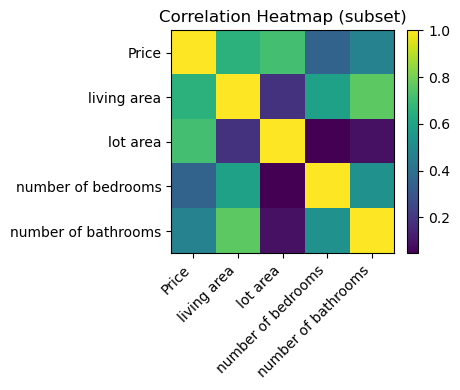

In [14]:
if len(cols_for_corr) > 1:
    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, interpolation='nearest')
    plt.xticks(range(len(cols_for_corr)), cols_for_corr, rotation=45, ha='right')
    plt.yticks(range(len(cols_for_corr)), cols_for_corr)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Correlation Heatmap (subset)')
    plt.tight_layout()
    plt.show()


In [15]:
# --- Basic cleaning ---
for col in ['id', 'Postal Code']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# --- Date handling ---
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df.drop(columns=['Date'], inplace=True)

# --- Categorical encoding ---
property_type_encoder = None
city_encoder = None

if 'property_type' in df.columns:
    property_type_encoder = LabelEncoder()
    df['property_type_encoded'] = property_type_encoder.fit_transform(df['property_type'])
else:
    df['property_type_encoded'] = 0

if 'city' in df.columns:
    city_encoder = LabelEncoder()
    df['city_encoded'] = city_encoder.fit_transform(df['city'])
else:
    df['city_encoded'] = 0

if property_type_encoder is not None:
    with open("property_type_encoder.pkl", "wb") as f:
        pickle.dump(property_type_encoder, f)

if city_encoder is not None:
    with open("city_encoder.pkl", "wb") as f:
        pickle.dump(city_encoder, f)

# --- Feature engineering ---
# Ensure Renovation Year & Built Year exist
if 'Renovation Year' not in df.columns:
    df['Renovation Year'] = 0

if 'Built Year' not in df.columns:
    df['Built Year'] = 0

df['Was_Renovated'] = (df['Renovation Year'] > 0).astype(int)

def years_between_build_and_renov(row):
    by = row['Built Year']
    ry = row['Renovation Year']
    if by > 0 and ry > 0:
        return max(by - ry, 0)
    return 0

df['Years_Between_Build_And_Renov'] = df.apply(years_between_build_and_renov, axis=1)

# Density / ratio features
df['Living_vs_Lot_Ratio'] = df['living area'] / df['lot area'].replace(0, 1)

# Interaction features
df['bedrooms_x_bathrooms'] = df['number of bedrooms'] * df['number of bathrooms']
df['area_per_bedroom'] = df['living area'] / (df['number of bedrooms'] + 1)
df['lot_per_living'] = df['lot area'] / (df['living area'] + 1)
df['lat_x_lon'] = df['Lattitude'] * df['Longitude']

logging.info("Cleaning, encoding, and feature engineering complete.")
df.head()


2025-11-20 18:14:36,442 - INFO - Cleaning, encoding, and feature engineering complete.


,number of bedrooms,number of bathrooms,living area,lot area,number of floors,waterfront present,number of views,condition of the house,grade of the house,Area of the house(excluding basement),...,Quarter,property_type_encoded,city_encoded,Was_Renovated,Years_Between_Build_And_Renov,Living_vs_Lot_Ratio,bedrooms_x_bathrooms,area_per_bedroom,lot_per_living,lat_x_lon
0,3,1.75,1510,6597,1.0,0,0,4,6,950,...,1,1,4,0,0,0.228892,5.25,377.500000,4.365983,1356.756568
1,2,2.50,1310,1500,2.0,0,0,3,8,1160,...,1,1,7,0,0,0.873333,5.00,436.666667,1.144165,2190.197326
2,3,2.25,3270,168000,2.0,0,0,4,10,3270,...,1,1,7,0,0,0.019464,6.75,817.500000,51.360440,2165.678811
3,3,1.00,1340,10035,1.0,0,0,3,7,1340,...,1,1,1,0,0,0.133533,3.00,335.000000,7.483221,1025.387083
4,4,2.50,2500,8540,2.0,0,0,3,9,2500,...,1,1,1,0,0,0.292740,10.00,500.000000,3.414634,1013.083244


In [16]:
TARGET_COL = "Price"

def cap_iqr(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return s.clip(lower, upper)

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col != TARGET_COL:
        df[col] = cap_iqr(df[col])

logging.info("IQR capping applied.")


2025-11-20 18:14:38,393 - INFO - IQR capping applied.


In [17]:
# Broad candidate feature set for diagnostics (OLS/VIF)
candidate_features = [
    'number of bedrooms',
    'number of bathrooms',
    'living area',
    'lot area',
    'waterfront present',
    'number of views',
    'grade of the house',
    'Area of the basement',
    'Lattitude',
    'Longitude',
    'Years_Between_Build_And_Renov',
    'Was_Renovated',
    'Living_vs_Lot_Ratio',
    'floor',
    'property_type_encoded',
    'city_encoded',
    'bedrooms_x_bathrooms',
    'area_per_bedroom',
    'lot_per_living',
    'lat_x_lon',
    'Year',
    'Month',
    'Quarter'
]

present_features = [f for f in candidate_features if f in df.columns]
logging.info(f"Candidate features present: {len(present_features)}")

X_full = df[present_features].copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


2025-11-20 18:14:38,892 - INFO - Candidate features present: 23


((24000, 23), (6000, 23))

In [18]:
# VIF diagnostics
def compute_vif(X_df):
    Xc = sm.add_constant(X_df)
    vifs = []
    for i in range(Xc.shape[1]):  # skip constant
        vifs.append(variance_inflation_factor(Xc.values, i))
    return pd.Series(vifs, index=X_df.columns).sort_values(ascending=False)

vif_series = compute_vif(X_train)
vif_series


lat_x_lon                        2959.836277
Lattitude                        2755.798232
Longitude                         153.975171
living area                        53.405642
bedrooms_x_bathrooms               36.732927
area_per_bedroom                   34.724867
number of bathrooms                17.860192
number of bedrooms                 13.501664
lot area                           11.893314
lot_per_living                      9.246200
Living_vs_Lot_Ratio                 4.254213
grade of the house                  2.842073
city_encoded                        2.113082
Area of the basement                1.330176
floor                               1.082124
property_type_encoded               1.081735
Year                                0.000000
Month                               0.000000
Quarter                             0.000000
waterfront present                       NaN
number of views                          NaN
Years_Between_Build_And_Renov            NaN
Was_Renova

In [19]:
# OLS regression for interpretability (not used directly for prediction)
Xc = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, Xc).fit()
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     1744.
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:14:44   Log-Likelihood:            -4.0909e+05
No. Observations:               24000   AIC:                         8.182e+05
Df Residuals:                   23983   BIC:                         8.183e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
number of bedr

### Choosing the final 13 features

Based on:

- OLS p-values (statistical significance)
- VIF (multicollinearity)
- XGBoost feature importances
- Domain intuition

we keep a **clean 13-feature set** that is both interpretable and predictive.

In [20]:
final_features = [
    'living area',
    'lot area',
    'number of bedrooms',
    'number of bathrooms',
    'floor',
    'property_type_encoded',
    'Lattitude',
    'Longitude',
    'lat_x_lon',
    'Living_vs_Lot_Ratio',
    'area_per_bedroom',
    'lot_per_living',
    'bedrooms_x_bathrooms'
]

# Make sure all exist
final_features = [f for f in final_features if f in X_train.columns]
logging.info(f"Final features used for model: {len(final_features)}")
final_features


2025-11-20 18:14:46,414 - INFO - Final features used for model: 13


['living area',
 'lot area',
 'number of bedrooms',
 'number of bathrooms',
 'floor',
 'property_type_encoded',
 'Lattitude',
 'Longitude',
 'lat_x_lon',
 'Living_vs_Lot_Ratio',
 'area_per_bedroom',
 'lot_per_living',
 'bedrooms_x_bathrooms']

In [21]:
log_target = True

X_train_final = X_train[final_features].copy()
X_test_final = X_test[final_features].copy()
y_train_log = np.log1p(y_train)

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=5,
    reg_lambda=1.0,
    random_state=42
)

xgb_model.fit(X_train_final, y_train_log)
logging.info("XGBoost training complete.")


2025-11-20 18:14:53,107 - INFO - XGBoost training complete.


In [22]:
y_pred_log = xgb_model.predict(X_test_final)
y_pred = np.expm1(y_pred_log) if log_target else y_pred_log

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("MAPE:", mape)
print("R²  :", r2)


MAE : 1831344.5
MAPE: 14.052166044712067
R²  : 0.8759323358535767


In [23]:
# Feature importances
imp_df = pd.DataFrame({
    'feature': final_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
imp_df


,feature,importance
0,living area,0.413716
2,number of bedrooms,0.130814
9,Living_vs_Lot_Ratio,0.082787
10,area_per_bedroom,0.074364
5,property_type_encoded,0.067129
1,lot area,0.055497
11,lot_per_living,0.044247
6,Lattitude,0.043770
7,Longitude,0.024052
12,bedrooms_x_bathrooms,0.023383


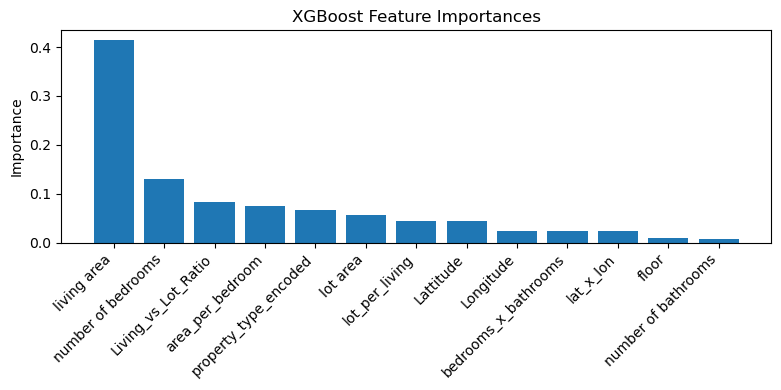

In [24]:
plt.figure(figsize=(8,4))
plt.bar(imp_df['feature'], imp_df['importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()


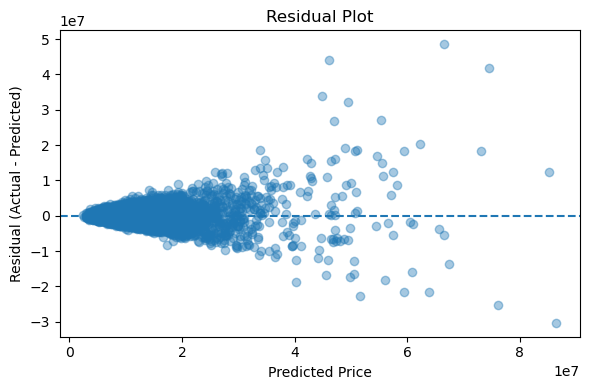

In [25]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.tight_layout()
plt.show()


In [26]:
with open("best_house_price_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

with open("model_features.pkl", "wb") as f:
    pickle.dump(final_features, f)

with open("model_config.pkl", "wb") as f:
    pickle.dump({"log_target": log_target, "model_type": "xgboost"}, f)

logging.info("Model artifacts saved.")


2025-11-20 18:15:01,722 - INFO - Model artifacts saved.


In [27]:
def load_encoders():
    pe, ce = None, None
    try:
        pe = pickle.load(open("property_type_encoder.pkl", "rb"))
    except Exception:
        pass
    try:
        ce = pickle.load(open("city_encoder.pkl", "rb"))
    except Exception:
        pass
    return pe, ce

def predict_price(input_dict: dict) -> float:
    """Production-style prediction function using the saved model."""
    model = pickle.load(open("best_house_price_model.pkl", "rb"))
    features = pickle.load(open("model_features.pkl", "rb"))
    config = pickle.load(open("model_config.pkl", "rb"))
    pe, ce = load_encoders()

    d = input_dict.copy()

    # Encode property type
    if "property_type_encoded" not in d:
        if pe is not None and "property_type" in d:
            val = d["property_type"]
            if isinstance(val, str):
                if val not in pe.classes_:
                    raise ValueError(f"Unknown property_type: {val}")
                d["property_type_encoded"] = int(pe.transform([val])[0])
            else:
                d["property_type_encoded"] = int(val)
        else:
            d["property_type_encoded"] = 0

    # Engineered features
    # (We recompute them so the API user doesn't have to send them.)
    if "number of bedrooms" not in d or "number of bathrooms" not in d:
        raise KeyError("number of bedrooms and number of bathrooms are required.")

    if "living area" not in d or "lot area" not in d:
        raise KeyError("living area and lot area are required.")

    d["bedrooms_x_bathrooms"] = d["number of bedrooms"] * d["number of bathrooms"]
    d["Living_vs_Lot_Ratio"] = d["living area"] / max(d["lot area"], 1)
    d["area_per_bedroom"] = d["living area"] / (d["number of bedrooms"] + 1)
    d["lot_per_living"] = d["lot area"] / (d["living area"] + 1)

    if "Lattitude" not in d or "Longitude" not in d:
        raise KeyError("Lattitude and Longitude are required.")
    d["lat_x_lon"] = d["Lattitude"] * d["Longitude"]

    # Build dataframe
    for f in features:
        if f not in d:
            raise KeyError(f"Missing required feature: {f}")

    df_input = pd.DataFrame([{f: d[f] for f in features}])

    # Type check
    for col in df_input.columns:
        if not np.issubdtype(type(df_input[col].iloc[0]), np.number):
            raise TypeError(f"Feature '{col}' must be numeric, got {type(df_input[col].iloc[0])}.")

    pred_log = model.predict(df_input)
    if np.isnan(pred_log).any():
        raise ValueError("Model prediction is NaN.")

    if config.get("log_target", False):
        return float(np.expm1(pred_log)[0])
    return float(pred_log[0])

logging.info("predict_price() is ready.")


2025-11-20 18:15:03,083 - INFO - predict_price() is ready.


In [28]:
sample1 = {
    "number of bedrooms": 3,
    "number of bathrooms": 2,
    "living area": 1200,
    "lot area": 2000,
    "floor": 2,
    "Lattitude": 28.4595,
    "Longitude": 77.0266,
    "property_type": "Flat"
}

sample2 = sample1.copy()
sample2["living area"] = 900  # smaller flat

sample3 = sample1.copy()
sample3["lot area"] = 1500  # smaller plot size

print("Sample 1 price:", predict_price(sample1))
print("Sample 2 price:", predict_price(sample2))
print("Sample 3 price:", predict_price(sample3))


Sample 1 price: 5971503.5
Sample 2 price: 4482437.0
Sample 3 price: 6136074.5
